# the workflow is based on
### article:
https://www.nature.com/articles/s41587-019-0387-5
### jupyter notebook:
https://static-content.springer.com/esm/art%3A10.1038%2Fs41587-019-0387-5/MediaObjects/41587_2019_387_MOESM4_ESM.html
    

## versions needed:

### tensorflow 1.15.0
`conda install -c anaconda tensorflow==1.15.0`

### keras 2.2.4
`conda install -c anaconda keras==2.2.4`


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import itertools
from scipy.stats import pearsonr
from collections import Counter
from keras.layers import Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential
#from tensorflow.keras.models import Sequential, load_model
from Bio.SeqIO.FastaIO import SimpleFastaParser  # low level fast fasta parser
import pandas as pd
import seaborn as sns
sns.set()

Using TensorFlow backend.


In [2]:
np.set_printoptions(linewidth=100)


In [3]:
data = pd.read_table('tables/Table_S8_machine_learning_input.txt', index_col=0)


In [4]:
data.head()

,perfect match sgRNA,gene,sgRNA sequence,mismatch position,new pairing,K562,Jurkat,mean relative gamma,genome input,sgRNA input
AAR2_-_34824434.23-P1P2_01,AAR2_-_34824434.23-P1P2,AAR2,GTGAGGCGAGGCGGTGAGTG,-17.0,rA:dC,True,False,0.665625,ACGTGGGGCGAGGCGGTGAGTGTGGC,ACGTGAGGCGAGGCGGTGAGTGTGGC
AAR2_-_34824434.23-P1P2_02,AAR2_-_34824434.23-P1P2,AAR2,GTGGGACGAGGCGGTGAGTG,-15.0,rA:dC,True,False,0.596488,ACGTGGGGCGAGGCGGTGAGTGTGGC,ACGTGGGACGAGGCGGTGAGTGTGGC
AAR2_-_34824434.23-P1P2_03,AAR2_-_34824434.23-P1P2,AAR2,GTGGGGGGAGGCGGTGAGTG,-14.0,rG:dG,True,False,0.629915,ACGTGGGGCGAGGCGGTGAGTGTGGC,ACGTGGGGGGAGGCGGTGAGTGTGGC
AAR2_-_34824434.23-P1P2_04,AAR2_-_34824434.23-P1P2,AAR2,GTGGGGCGAAGCGGTGAGTG,-11.0,rA:dC,True,False,-0.012634,ACGTGGGGCGAGGCGGTGAGTGTGGC,ACGTGGGGCGAAGCGGTGAGTGTGGC
AAR2_-_34824434.23-P1P2_05,AAR2_-_34824434.23-P1P2,AAR2,GTGGGGCGACGCGGTGAGTG,-11.0,rC:dC,True,False,0.058972,ACGTGGGGCGAGGCGGTGAGTGTGGC,ACGTGGGGCGACGCGGTGAGTGTGGC


In [5]:
# print some statistics from this dataset

print ('total sgRNAs:', len(data))
print ('total series:', len(data['perfect match sgRNA'].unique()))
print ('total genes:', len(data['gene'].unique()))
print ('phenotypes from K562 and Jurkat: %.2f%%'%(len(data[(data.K562==True) & (data.Jurkat==True)])/
                                                 float(len(data))*100))

total sgRNAs: 26248
total series: 2034
total genes: 1292
phenotypes from K562 and Jurkat: 39.61%


In [6]:
# make a list of tuples pairing genome and input sequences

sequence_tuples = list(zip(data['genome input'], data['sgRNA input']))

In [7]:
def binarize_sequence(sequence):
    """
    converts a 26-base nucleotide string to a binarized array of shape (4,26)
    """
    arr = np.zeros((4, 26))
    for i in range(26):
        if sequence[i] == 'A':
            arr[0,i] = 1
        elif sequence[i] == 'C':
            arr[1,i] = 1
        elif sequence[i] == 'G':
            arr[2,i] = 1
        elif sequence[i] == 'T':
            arr[3,i] = 1
        else:
            raise Exception('sequence contains characters other than A,G,C,T \n%s'%sequence)
 
    return arr

ACGTGGGGCGAGGCGGTGAGTGTGGC 

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.]] 

(4, 26) 



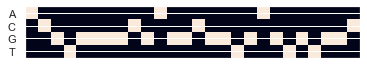

In [8]:
# example of what the above function is doing
# using the genome input sequence from the first row of the data table

test_sequence = sequence_tuples[0][0]
print (test_sequence, '\n')
print (binarize_sequence(test_sequence), '\n')
print (binarize_sequence(test_sequence).shape, '\n')

fig,ax=plt.subplots()
ax.imshow(binarize_sequence(test_sequence))
ax.set_yticks(range(4))
ax.set_yticklabels(list('ACGT'))
ax.set_xticks([]);

In [9]:

# for each tuple, binarize the sequences and stack them into a 3D array of shape (4,26,2)

stacked_arrs = [np.stack((binarize_sequence(genome_input), binarize_sequence(sgrna_input)), axis=2) 
                for (genome_input, sgrna_input) in sequence_tuples]

In [10]:
# the feature input X is a 4D array containing all of the 3D arrays generated above

X = np.concatenate([arr[np.newaxis] for arr in stacked_arrs])

In [11]:
# the target input y is a 1D array of relative activities

y = data['mean relative gamma'].values

In [12]:
# an array of series IDs will allow mapping of each element in X or y
# to be used in assigning each series to the training or validation set

series = data['perfect match sgRNA']

In [13]:
# check the shape of each array

print ('X:', X.shape)
print ('y:', y.shape)
print ('series:', series.shape)

X: (26248, 4, 26, 2)
y: (26248,)
series: (26248,)


In [14]:
# randomly select 20% of sgRNA series to be set aside for validation

np.random.seed(99)
val_series = np.random.choice(np.unique(series), size=int(len(np.unique(series))*.20), replace=False)
val_indices = np.where(np.isin(series, val_series))
train_indices = np.where(~np.isin(series, val_series))

In [15]:
# define train and validation sets

X_train = X[train_indices]
X_val = X[val_indices]
y_train = y[train_indices]
y_val = y[val_indices]

In [16]:
# check the shape of each array

print ('X train:', X_train.shape)
print ('y train:', y_train.shape, '\n')
print ('X validation:', X_val.shape)
print ('y validation:', y_val.shape)

X train: (21007, 4, 26, 2)
y train: (21007,) 

X validation: (5241, 4, 26, 2)
y validation: (5241,)


In [17]:
# assign training target values to 5 bins with evenly spaced edges
# relative activities below 0 or above 1 are included in the lowest or highest bin, respectively

nbins=5
y_train_clipped = y_train.clip(0,1)
y_train_binned, histbins = pd.cut(y_train_clipped, np.linspace(0,1,nbins+1), 
                                  labels=range(nbins), include_lowest=True, retbins=True)

In [18]:
print ('bin edges:', histbins)

bin edges: [0.  0.2 0.4 0.6 0.8 1. ]


In [19]:
# calculate a weight for each bin, inversely proportional to the population in that bin

class_weights = {k:1/float(v) for k,v in Counter(y_train_binned).items()}

In [20]:
# increase the class 0 weight by multiplying by 1.5
# this empirically improved model accuracy during parameter optimization on the training data

class_weights[0] = class_weights[0] * 1.5

In [21]:
# scale weights to sum to 1

class_weights = {k:v/sum(class_weights.values()) for k,v in class_weights.items()}
class_weights

{3: 0.24366538202754034,
 2: 0.2879094606727001,
 0: 0.050152613839668826,
 4: 0.13670716682036013,
 1: 0.2815653766397307}

In [22]:
# generate a list mapping each element in y_train to its class weight

sample_weights = [class_weights[Y] for Y in y_train_binned]

In [23]:
# build and compile the CNN model

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', input_shape=(4,26,2), data_format='channels_last'))
model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', data_format='channels_last'))
model.add(MaxPool2D(pool_size=(1,2), padding='same', data_format='channels_last'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
model.compile(loss='logcosh', metrics=['mse'], optimizer='adam')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [24]:
# train the model for 10 epochs

model_history_10_ep = model.fit(X_train, 
                          y_train.ravel(), 
                          sample_weight=np.array(sample_weights), 
                          batch_size=32, 
                          epochs=10, 
                          validation_data=(X_val, y_val.ravel()))




Train on 21007 samples, validate on 5241 samples
Epoch 1/10





21007/21007 [==============================] - 53s 3ms/step - loss: 0.0068 - mean_squared_error: 0.1592 - val_loss: 0.0406 - val_mean_squared_error: 0.0844
Epoch 2/10
21007/21007 [==============================] - 52s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0835 - val_loss: 0.0360 - val_mean_squared_error: 0.0747
Epoch 3/10
21007/21007 [==============================] - 52s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0737 - val_loss: 0.0386 - val_mean_squared_error: 0.0801
Epoch 4/10
21007/21007 [==============================] - 53s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0673 - val_loss: 0.0371 - val_mean_squared_error: 0.0769
Epoch 5/10
21007/21007 [==============================] - 52s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0628 - val_loss: 0.0302 - val_mean_squared_error: 0.0629
Epoch 6/10
21007/21007 [==============================] - 52s 2ms/step - loss: 0.0032 - mean_squared_error: 

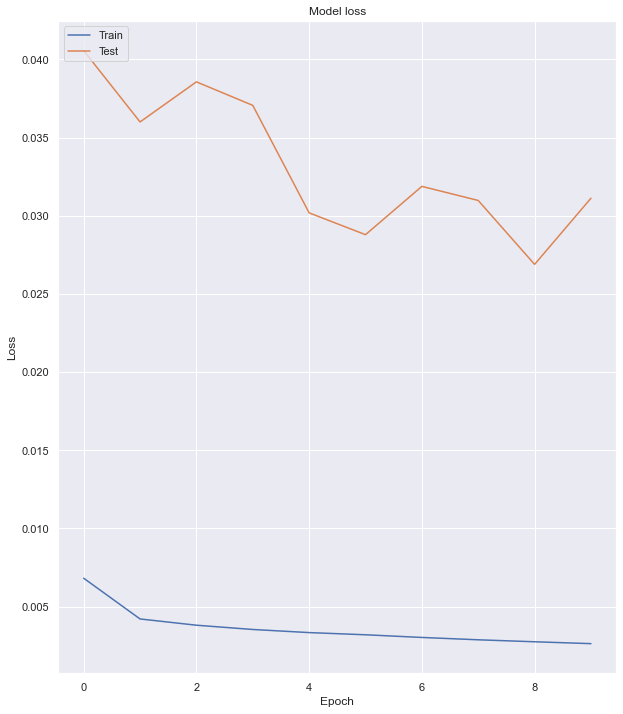

In [25]:
# Plot training & validation loss values ep 10
fig = plt.figure(figsize=(10, 12))
plt.plot(model_history_10_ep.history['loss'])
plt.plot(model_history_10_ep.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

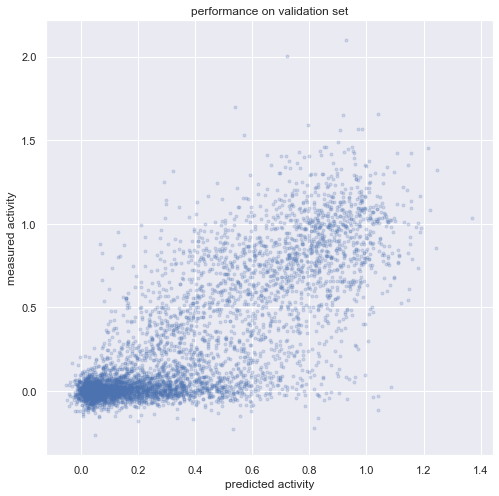

In [26]:
# plot measured vs. predicted relative activity ep 14

fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(model.predict(X_val), y_val, marker='.', alpha=.2)
ax.set_xlabel('predicted activity')
ax.set_ylabel('measured activity')
ax.set_title('performance on validation set');

In [27]:
print ('r squared = %.3f'%pearsonr(y_val, model.predict(X_val).ravel())[0]**2)


r squared = 0.619


In [28]:
# starting from the sgRNA and corresponding genomic sequences

                             #
sgrna  = 'TAGGTACTGAGCGCGCGAGCTGAGGA'
genome = 'TAGGTACTGAGCGCGCGAGGTGAGGA'
                             # -3 rC:dC

In [29]:
def get_predicted_activity(genome_seq, sgrna_seq, cnn_model):
    """
    takes 26-nt sgRNA and genome sequences, plus a trained model
    outputs the predicted relative activity of the sgRNA
    """
    X = np.stack((binarize_sequence(genome_seq), 
                  binarize_sequence(sgrna_seq)), axis=2)[np.newaxis]
    
    return cnn_model.predict(X)[0][0]

In [30]:
print(get_predicted_activity(genome, sgrna, model))


0.025334597


### `main()` takes input file with sgRNAs (5'-3'), calls the model and saves the output in spreadsheets

In [31]:
def main(input_sgRNA):
    
    mismatches = ["A", "T", "G", "C"]

    with open(input_sgRNA) as in_handle:
        for sg_rna_title, sg_rna_seq in SimpleFastaParser(in_handle):
            
            data_out = pd.DataFrame(columns=["genome_input", "sgRNA_input","mismatch_pos",
                                "mismatch_itself", "predicted_activity"])
            
            sg_rna_seq_cut = sg_rna_seq[2 : -4]
            sg_rna_head = sg_rna_seq[:2]
            sg_rna_tail = sg_rna_seq[22:]
            
            current_position = -1
            for nuc in sg_rna_seq_cut[::-1]:
                for mismatch in mismatches:
                    if nuc == mismatch:
                        continue
        
                    sg_rna_seq_cut_mis = list(sg_rna_seq_cut)
                    sg_rna_seq_cut_mis[current_position] = mismatch # mismatch
                    sg_rna_seq_cut_mis_repared = sg_rna_head + "".join(sg_rna_seq_cut_mis) + sg_rna_tail
                    # put prints here
                    current_out = {"genome_input" : sg_rna_seq,
                                "sgRNA_input" : sg_rna_seq_cut_mis_repared,
                                "mismatch_pos" : current_position,
                                "mismatch_itself" : mismatch,
                                "predicted_activity" : get_predicted_activity(sg_rna_seq, sg_rna_seq_cut_mis_repared, 
                                                                              model)}
                    data_out = data_out.append(current_out, ignore_index=True)
                current_position -= 1 
            data_out.to_excel(sg_rna_title + ".xlsx")


In [33]:
main("input_sgRNA.fasta")

In [38]:
ls

 Том в устройстве C не имеет метки.
 Серийный номер тома: 64D4-AB32

 Содержимое папки C:\Users\yuriy\cnn_sgRNA

17.02.2020  15:14    <DIR>          .
17.02.2020  15:14    <DIR>          ..
17.02.2020  15:05    <DIR>          .ipynb_checkpoints
17.02.2020  15:14             7 205 AID.xlsx
17.02.2020  15:14             7 201 APOBEC3A.xlsx
17.02.2020  15:14             7 217 APOBEC3B.xlsx
17.02.2020  15:14             7 205 APOBEC3G.xlsx
14.02.2020  17:21            15 972 draft_iterate_sgRNA.ipynb
17.02.2020  13:46               153 input_sgRNA.fasta.txt
17.02.2020  15:13           148 364 main_workflow.ipynb
11.02.2020  11:22    <DIR>          tables
17.02.2020  15:09           810 953 workflow_draft.ipynb
               8 файлов      1 004 270 байт
               4 папок  446 086 012 928 байт свободно


In [39]:
aid_df = pd.read_excel("AID.xlsx")
apobec3a_df = pd.read_excel("APOBEC3A.xlsx")
apobec3b_df = pd.read_excel("APOBEC3B.xlsx")
apobec3g_df = pd.read_excel("APOBEC3G.xlsx")

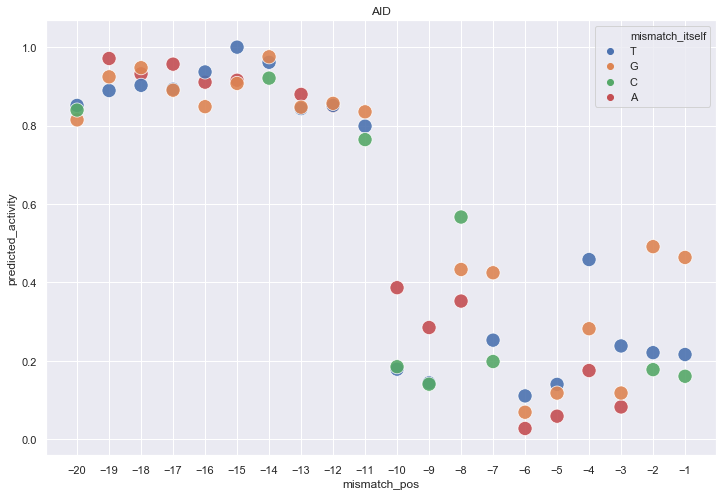

In [42]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=aid_df["mismatch_pos"], 
                y=aid_df["predicted_activity"], 
                hue=aid_df["mismatch_itself"],
               s=200, alpha=0.9)

plt.xticks(list(range(-20, -0, 1)))

plt.title("AID")

plt.show()

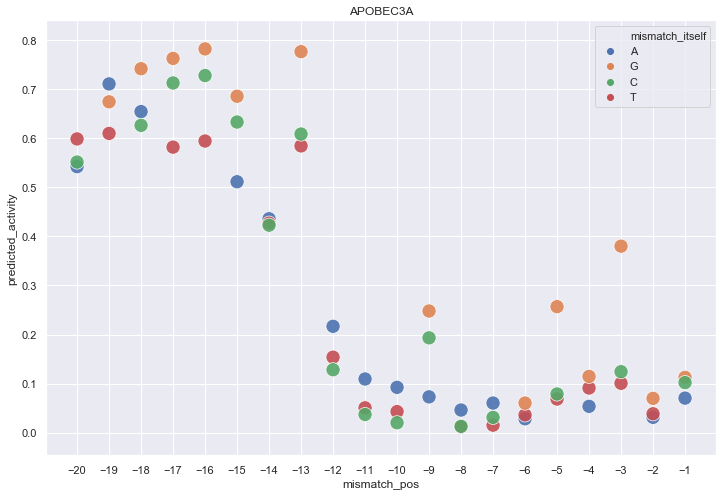

In [43]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=apobec3a_df["mismatch_pos"], 
                y=apobec3a_df["predicted_activity"], 
                hue=apobec3a_df["mismatch_itself"],
               s=200, alpha=0.9)

plt.xticks(list(range(-20, -0, 1)))

plt.title("APOBEC3A")

plt.show()

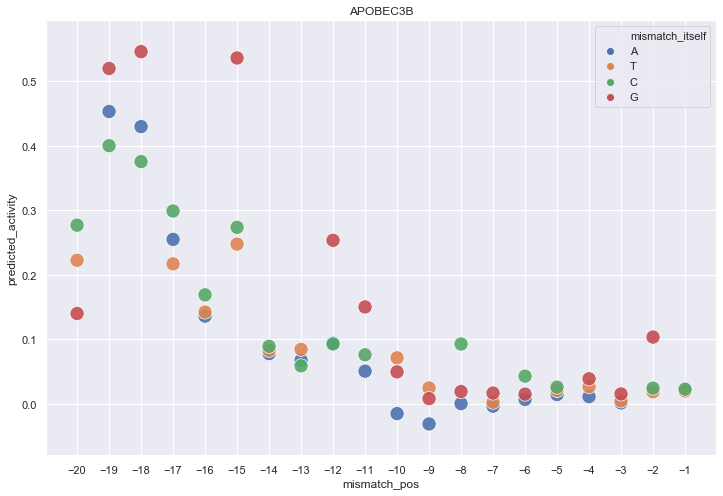

In [44]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=apobec3b_df["mismatch_pos"], 
                y=apobec3b_df["predicted_activity"], 
                hue=apobec3b_df["mismatch_itself"],
               s=200, alpha=0.9)

plt.xticks(list(range(-20, -0, 1)))

plt.title("APOBEC3B")

plt.show()

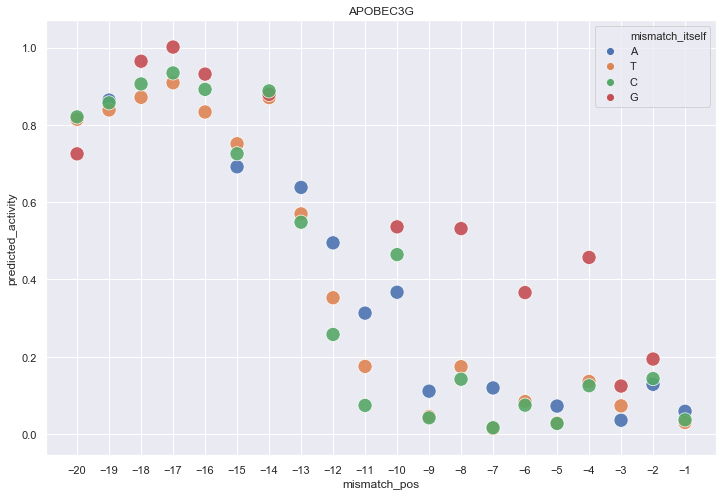

In [45]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=apobec3g_df["mismatch_pos"], 
                y=apobec3g_df["predicted_activity"], 
                hue=apobec3g_df["mismatch_itself"],
               s=200, alpha=0.9)

plt.xticks(list(range(-20, -0, 1)))

plt.title("APOBEC3G")

plt.show()